In [ ]:
def identify_concepts(x, labels, label_of_interest, index_manager, device) -> float:
    y = labels == label_of_interest

    # Shuffle
    # perm = torch.randperm(n)
    # samples = samples[perm]
    # labels = labels[perm]
    # x = x[perm]
    # y = y[perm]

    # n_label_of_interest = (labels == label_of_interest).cpu().sum().item()
    # indices = torch.nonzero(y).squeeze(1)
    # non_indices = torch.nonzero(~y).squeeze(1)
    # x = torch.cat([x[indices], x[non_indices][:n_label_of_interest]]).to(device)
    # y = torch.cat([y[indices], y[non_indices][:n_label_of_interest]]).to(device)
    # samples = torch.cat([samples[indices], samples[non_indices][:n_label_of_interest]]).to(device)
    # labels = torch.cat([labels[indices], labels[non_indices][:n_label_of_interest]]).to(device)

    x = x[index_manager[label_of_interest]]
    y = y[index_manager[label_of_interest]]
    labels = labels[index_manager[label_of_interest]]

    # print(f"Number of samples: {x.shape[0]}")

    test_size = 0.25
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=745)
    clf = LogisticRegression()
    clf.fit(x_train.reshape(x_train.shape[0], -1).cpu(), y_train.cpu())
    accuracy = clf.score(x_test.reshape(x_test.shape[0], -1).cpu(), y_test.cpu())

    return accuracy

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load the diffusion model
model = DDPM(eps_model=DummyEpsModel(1), betas=(1e-4, 0.02), n_T=1000)
model.load_state_dict(torch.load("./contents/ddpm_mnist.pth", map_location=device))
model.to(device)
model.eval()

dataset_name = "980"

# Load samples, labels and seeds
dataset = torch.load(f"./datasets/{dataset_name}_samples.pth", map_location=device)
labels = torch.load(f"./datasets/{dataset_name}_labels.pth", map_location=device)
seed = torch.load(f"./datasets/{dataset_name}_seed.pth", map_location=device)

n = dataset.shape[0]
# samples = dataset[:, 0][:, None, ...]
original_noise = dataset[:, 1][:, None, ...]


whole_pipeline = []
for m in model.eps_model.modules():
    if not isinstance(m, torch.nn.Sequential) and not isinstance(m, DummyEpsModel):
        whole_pipeline.append(m)
whole_net = torch.nn.Sequential(*whole_pipeline)

In [ ]:
steps = list(range(1000, 0, -1))
digits_to_test = [3]
test_every = 100
logging_dir = f"./tcav_results/seeded_test"
if not isdir(logging_dir):
    os.mkdir(logging_dir)

layers_to_inspect_indices = [i for i, m in enumerate(whole_net) if isinstance(m, nn.Conv2d)]


# Create index manager, used when we create the datasets for each label of interest
index_manager = {}
for d in digits_to_test:
    is_label = labels == d
    n_digits = (is_label).cpu().sum().item()
    present_indices = torch.nonzero(is_label).squeeze(1)
    absent_indices = torch.nonzero(~is_label).squeeze(1)
    indices = torch.cat([present_indices, absent_indices[:n_digits]]).to(device)
    index_manager[d] = indices



In [ ]:
results_list = []
x_t = original_noise

with torch.no_grad():
    rng = torch.manual_seed(seed)
    _ = torch.randn(n, *(1, 28, 28)).to(device) # Continue RNG state
    # Loop for T..1
    for t in steps:
        print(f"Step: {t}")
        z = torch.randn(n, *(1, 28, 28)).to(device) if t > 1 else 0
        eps = x_t.clone()
            
        if t%test_every == 0 or t==1: # Apply each layer individually
            print(f"Testing at {t}")
            for i, layer in enumerate(whole_pipeline):
                
                eps = layer(eps) 
                if i in layers_to_inspect_indices:
                    # Suspend RNG
                    curr_rng_state = rng.get_state()
                    print(f"Testing layer {i}")

                    for label_of_interest in digits_to_test:
                        #Identify concepts here
                        x = x[index_manager[label_of_interest]]
                        y = y[index_manager[label_of_interest]]
                        labels = labels[index_manager[label_of_interest]]

                        # print(f"Number of samples: {x.shape[0]}")

                        test_size = 0.25
                        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=745)
                        clf = LogisticRegression()
                        clf.fit(x_train.reshape(x_train.shape[0], -1).cpu(), y_train.cpu())
                        accuracy = clf.score(x_test.reshape(x_test.shape[0], -1).cpu(), y_test.cpu())
                        results_list.append([t, i, label_of_interest, accuracy])

                    # Resume RNG
                    rng.set_state(curr_rng_state)
        else: # Apply the whole network
            eps = whole_net(x_t)


        x_t = (model.oneover_sqrta[t] * (x_t - eps * model.mab_over_sqrtmab[t]) + model.sqrt_beta_t[t] * z)

print(x_t.shape)
# Plot the samples
fig, axes = plt.subplots(1, 5, figsize=(10, 4))
for i, ax in enumerate(np.array(list(axes)).T):
    ax.imshow(x_t[i].mean(dim=0).reshape(28, 28), cmap="gray")
    # ax.set_title(f"Label: {predicted}")
    # ax.imshow(samples_test[i].reshape(28, 28), cmap="gray")
# Save the figure
fig.savefig(f"{logging_dir}/{dataset_name}_samples.png")


# results_list to dataframe with columns: t, layer, digit_separated, accuracy and indices

results = pd.DataFrame(results_list, columns=["t", "layer", "digit_separated", "accuracy"])
results.index.name = "id"
results.to_csv(f"{logging_dir}/{dataset_name}_results.csv")

In [14]:
from superminddpm import ddpm_schedules
import matplotlib.pyplot as plt
import numpy as np
import torch

schedule = ddpm_schedules(1e-4, 0.02, 1000)


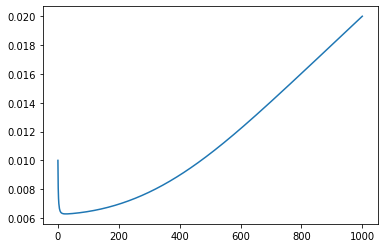

In [23]:
# plt.plot(schedule["alpha_t"])
# plt.plot(torch.sqrt(schedule["alpha_t"]))
# plt.plot(torch.sqrt(1-schedule["alpha_t"]))
# plt.plot(1 - schedule["alpha_t"])
plt.plot(((1 - schedule["alpha_t"]))/torch.sqrt(1-schedule["alphabar_t"]))
plt.show()